# Machine Learning Implementation

## Imports

In [1]:
import itertools
import json
import logging

import graphviz
import numpy as np
import pandas as pd
import plotly.offline as py
from graphviz import Digraph
from IPython.display import display
from plotly import graph_objects as go
from sklearn.datasets import load_boston, load_iris
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz

## Random forest

### The maths

A random forest uses a collection of decision trees to predict data using the average values of the trees. 

The trees are trained on bootstrap samples (with replacement) of the same size as the input using a random subset of the features at each node split (normally sqrt(total number of features)).

#### Classification

Some variations of a random forest classifiers use majority voting however in my implementation I will take the class probabilities as the average across the trees in the random forest. Note this is the same as Sklearn.

#### Regression

In the regression setting the output of the random forest is simply the average of all the tree outputs.

### Define the forest

In [2]:
logging.basicConfig()
logger = logging.getLogger('decision_tree')
logger.setLevel(logging.INFO)

logger.info(f'New logger with name {logger.name}')

INFO:decision_tree:New logger with name decision_tree


In [3]:

class TreeNode():

    count = itertools.count()

    def __init__(self,
                 data,
                 max_depth,
                 min_samples_split,
                 min_samples_leaf,
                 n_classes=2,
                 max_features=None,
                 depth=0,
                 impurity='gini',
                 is_classifier=True):
        """
        A single node in a decision tree

        After recursive splitting of the input data, a given node 
        represents one split of the tree if it is not a leaf node. The
        leaf node stores the training samples in that leaf to be used 
        for prediction. 
        The splitting nodes record the feature to split on as attribute 
        self.best_feature_index and the splitting value as attribute
        self.best_feature_split_val

        Parameters:
        ----------
        data: numpy.ndarray
            The input data with shape (m samples, n features + 1 target)
            Note the last column of the data are the target values
        max_depth: int
            The maximum depth allowed when "growing" a tree
        min_samples_split: int
            The minimum number of samples required to allow a split at
            a the node
        min_samples_leaf: int
            The minimum number of samples allowed in a leaf. A split
            candidate leading to less samples in a node than the
            min_samples_leaf will be rejected
        n_classes: int, optional, default 2
            Number of classes in a classification setting. Ignored when
            self.is_classifier = False
        max_features: int, optional, default None
            If set to 'sqrt' then only a random subset of features are
            used to split at the node, the number of features used in
            this case is sqrt(n_features).
            Else all the features are considered when splitting at this
            node
        depth: int, optional, default 0
            The depth of the node in the tree
        impurity: str, optional, default 'gini'
            The impurity measure to use when splitting at the node.
            I have currently only implemented two
            'gini' - Uses the gini impurity (for classification)
            'mse' - Uses the mean square error - equal to variance (for
            regression)
        is_classifier: bool, optional, default True
            Is the tree node used as part of a classification problem
            or a regression problem. Should be set to True if
            classification, False if regression
        """
        self.data = data
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.n_classes = n_classes
        self.max_features = max_features
        self.depth = depth
        self.impurity = impurity
        self.is_classifier = is_classifier

        self.data_shape = data.shape
        self.split_attempted = False
        self.best_split_impurity = None
        self.best_feature_index = None
        self.best_feature_split_val = None
        self.is_leaf = False
        self.node_impurity = self.calculate_impurity([data[:, -1]])
        self.value = self._init_value(data)
        self.id = str(next(self.count))

    def __repr__(self):
        return (
            f'<TreeNode '
            f'depth:{self.depth} '
            f'node_impurity:{self.node_impurity:.2f} '
            f'samples:{self.data_shape[0]} '
            f'{"🌳" if self.is_root else ""}'
            f'{"🍁" if self.is_leaf else ""}'
            f'>')

    @property
    def is_root(self):
        return self.depth == 0

    def info(self):
        return dict(
            data_shape=self.data_shape,
            n_classes=self.n_classes,
            depth=self.depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            node_impurity=self.node_impurity,
            split_attempted=self.split_attempted,
            best_split_impurity=self.best_split_impurity,
            best_feature_index=self.best_feature_index,
            best_feature_split_val=self.best_feature_split_val,
            is_root=self.is_root)

    def _init_value(self, data):
        """  
        Returns the terminal node value based on the input data

        For a classifier this is the class_counts.
        For a regressor this is the average y value. 

        Note this value can be access at a splitting node to see what
        the prediction would have been at that level of the tree

        Parameters:
        ----------
        data: numpy.ndarray
            The input data with shape (m samples, n features + 1 target)
            Note the last column of the data are the target values

        Returns:
        -------
        numpy.ndarray or float:
            Class counts if classifier, else mean of target values 
        """
        if self.is_classifier:
            return np.bincount(
                data[:, -1].astype(int),
                minlength=self.n_classes)
        else:
            return np.mean(data[:, -1])

    def split(self, feature_index, feature_split_val, only_y=True):
        """  
        Splits self.data on feature with index feature_index using
        feature_split_val.

        Each sample is included in left output if the feature value for
        the sample is less than or equal to the feature_split_val else 
        it is included in the right output

        Parameters:
        ----------
        feature_index: int
            Index of the feature (column) in self.data
        feature_split_val: float
            Feature value to use when splitting data
        only_y: bool, optional, default True
            Return only the y values in left and right - this is used 
            when checking candidate split purity increase

        Returns:
        -------
        (numpy.ndarray, numpy.ndarray):
            left and right splits of self.data
        """
        assert feature_index in range(self.data.shape[1])
        if only_y:
            select = -1
        else:
            select = slice(None)
        left_mask = self.data[:, feature_index] <= feature_split_val
        right_mask = ~ left_mask
        left = self.data[left_mask, select]
        right = self.data[right_mask, select]
        logger.debug(
            f'Splitting on feature_index {feature_index} with '
            f'feature_split_val = {feature_split_val} creates left '
            f'with shape {left.shape} and right with '
            f'shape {right.shape}')
        return left, right

    def gini_impurity(self, groups):
        """  
        Calculate the Gini impurity for groups of values

        The impurity returned is the weighted average of the impurity
        of the groups.

        You can think of gini impurity as the probability of incorrectly
        predicting a random sample from a group if the prediction was
        made based purely on the distribution of class labels in the
        group


        Parameters:
        ----------
        groups: tuple
            The groups tuple is made up of arrays of values. It is 
            often called with groups = (left, right) to find the purity
            of the candidate split

        Returns:
        -------
        float:
            Gini impurity
        """
        gini = 0
        total_samples = sum(group.shape[0] for group in groups)
        for i, group in enumerate(groups):
            group = group.astype(int)
            class_counts = np.bincount(group, minlength=self.n_classes)
            group_size = class_counts.sum()
            class_probs = class_counts / group_size
            unique_classes = np.count_nonzero(class_counts)
            group_gini = (class_probs * (1 - class_probs)).sum()
            gini += group_gini * (group_size / total_samples)
            logger.debug(
                f'Group {i} has size {group.shape[0]} with '
                f'{unique_classes} unique classes '
                f'with Gini index {group_gini:.3}')
        return gini

    def mean_square_impurity(self, groups):
        """  
        Calculates the mean square error impurity

        The mse impurity is the weighted average of the group variances

        Parameters:
        ----------
        groups: tuple
            The groups tuple is made up of arrays of values. It is 
            often called with groups = (left, right) to find the purity
            of the candidate split

        Returns:
        -------
        float:
            Mean square error impurity
        """
        mean_square_error = 0
        total_samples = sum(group.shape[0] for group in groups)
        for i, group in enumerate(groups):
            group_size = group.shape[0]
            group_mean = np.mean(group)
            group_mean_square_error = np.mean((group - group_mean) ** 2)
            mean_square_error += group_mean_square_error * \
                (group_size / total_samples)
            logger.debug(
                f'Group {i} has size {group.shape[0]} with '
                f'with MSE impurity {group_mean_square_error:.3}')
        logger.debug(f'MSE candidate {mean_square_error}')
        return mean_square_error

    def calculate_impurity(self, groups):
        """  
        Calculates impurity based on self.impurity setting

        Parameters:
        ----------
        groups: tuple
            The groups tuple is made up of arrays of values. It is 
            often called with groups = (left, right) to find the purity
            of the candidate split

        Returns:
        -------
        float:
            Mean square error of groups if self.impurity = 'mse'
            Gini impurity of groups if self.impurity = 'mse'
        """
        if self.impurity == 'gini':
            return self.gini_impurity(groups)
        elif self.impurity == 'mse':
            return self.mean_square_impurity(groups)

    def check_split(self, feature_index, feature_split_val):
        """  
        Updates best split if candidate split is better

        Splits the data in groups using self.split. Checks min samples
        leaf condition after split. Calculates impurity of the split
        then if impurity is less than best split already found and less
        than the current node impurity the best_feature_index, the 
        best_feature_split_val and the best_split_impurity values are
        updated.

        Parameters:
        ----------
        feature_index: int
            Index of the feature (column) in self.data
        feature_split_val: float
            Feature value to use when splitting data
        """
        groups = self.split(feature_index, feature_split_val)
        if any(len(group) < self.min_samples_leaf for group in groups):
            logger.debug(
                f"Can't split node on feature {feature_index} with split "
                f"val {feature_split_val} due to min_samples_leaf condition")
            return None
        split_impurity = self.calculate_impurity(groups)
        best_current_impurity = (
            10**10 if self.best_split_impurity is None
            else self.best_split_impurity)
        if ((split_impurity < best_current_impurity) and
                (split_impurity < self.node_impurity)):
            logger.debug(
                f'Found new best split with feature_split_val='
                f'{feature_split_val} for feature_index = {feature_index} '
                f'and split_impurity = {split_impurity:.2f}')
            self.best_feature_index = feature_index
            self.best_feature_split_val = feature_split_val
            self.best_split_impurity = split_impurity

    def find_best_split(self):
        """
        Finds best split at the node

        Loops through each feature and each unique value of that feature
        checking for the best candidate split (i.e. the split that 
        reduces the impurity the most)

        The function first checks if we have reached the max depth or if
        self.data < self.min_samples_split. In either case no further
        split is allowed and the function returns

        All features are considered unless self.max_features == 'sqrt'
        in which case a random subset of features are used of size
        sqrt(n_features)
        """
        if self.depth == self.max_depth:
            return
        if self.data.shape[0] < self.min_samples_split:
            logger.info(f"{self} can't split as samples < min_samples_split")
            return None
        if self.node_impurity == 0:
            logger.info(f"Can't improve as node pure")
            return None
        n_features = self.data.shape[1] - 1
        all_feature_indices = np.arange(n_features)
        if self.max_features == 'sqrt':
            features_to_check = np.random.choice(
                all_feature_indices,
                size=np.sqrt(n_features).astype(int))
        else:
            features_to_check = all_feature_indices
        logger.info(f'Checking features {features_to_check}')
        for feature_index in features_to_check:
            for feature_split_val in np.unique(self.data[:, feature_index]):
                self.check_split(feature_index, feature_split_val)
        self.split_attempted = True

    def recursive_split(self):
        """  
        Recursively grows tree by splitting to reduce impurity the most

        The function finds the best split using the find_best_split
        method. If there was a split found two nodes are created - left
        and right. Finally the recursive_split method is called on each
        of the new nodes.

        Note the depth of the children node is incremented, otherwise
        the node settings such as min_samples_split are passed to the
        children nodes
        """
        self.find_best_split()
        if self.best_feature_index is not None:
            logger.info(f'Splitting tree on feature_index '
                        f'{self.best_feature_index} and feature_split_val '
                        f'{self.best_feature_split_val:.2f}')
            left, right = self.split(
                feature_index=self.best_feature_index,
                feature_split_val=self.best_feature_split_val,
                only_y=False)
            del self.data
            self.left = TreeNode(
                data=left,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                n_classes=self.n_classes,
                max_features=self.max_features,
                depth=self.depth + 1,
                impurity=self.impurity,
                is_classifier=self.is_classifier)
            self.right = TreeNode(
                data=right,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                n_classes=self.n_classes,
                max_features=self.max_features,
                depth=self.depth + 1,
                impurity=self.impurity,
                is_classifier=self.is_classifier)
            self.left.recursive_split()
            self.right.recursive_split()
        else:
            logger.info('Reached max depth or no splits reduce impurity')
            self.is_leaf = True

    def walk_depth_first(self, only_leaves=True):
        """  
        Generator traversing of all nodes below and including this node

        Depth first so visiting children before siblings

        Parameters:
        ----------
        only_leaves: bool, optional, default True
            Only return leaf nodes

        Yields:
            TreeNode: each node in tree
        """
        if self.is_leaf:
            yield self
        else:
            if not only_leaves:
                yield self
            for node in (self.left, self.right):
                yield from node.walk_depth_first(only_leaves)

    def walk_breadth_first(self, layer=None):
        """  
        Generator traversing of all nodes below and including this node

        Breadth first so visiting siblings before children

        Parameters:
        ----------
        only_leaves: bool, optional, default True
            Only return leaf nodes

        Yields:
            TreeNode: each node in tree
        """
        if layer is None:
            layer = [self]
        for node in layer:
            yield node
        new_layer = [
            child
            for node_children in [[node.left, node.right]
                                  for node in layer if not node.is_leaf]
            for child in node_children]
        if new_layer:
            yield from self.walk_breadth_first(new_layer)

    def print_tree(self):
        """  
        prints ascii representation of tree below this node
        """
        for node in self.walk_depth_first(only_leaves=False):
            print('--' * node.depth + str(node))

    def predict_row_proba(self, row):
        """
        Predicts class probabilities for input row by walking the tree
        and returning the leaf node class probabilities

        Parameters:
        ----------
        row: numpy.ndarray
            Input row, shape (n features,)

        Returns:
        -------
        numpy.ndarray:
            Class probabilities, shape (n classes, )
        """
        if self.is_leaf:
            group_size = self.value.sum()
            class_probs = self.value / group_size
            return class_probs
        elif row[self.best_feature_index] <= self.best_feature_split_val:
            return self.left.predict_row_proba(row)
        else:
            return self.right.predict_row_proba(row)

    def predict_proba(self, data):
        """Predicts class probabilities for input data

        Predicts class probabilities for each row in data by walking the
        tree and returning the leaf node class probabilities

        Parameters:
        ----------
        data: numpy.ndarray
            The input data with shape (m samples, n features)

        Returns:
        -------
        numpy.ndarray:
            Predicted sample class probabilities, 
            shape (m samples, n classes)
        """
        if not self.is_classifier:
            raise Exception('Not a classifier')
        if len(data.shape) == 2:
            return np.stack([self.predict_row_proba(row)
                             for row in data])
        else:
            return self.predict_row_proba(data)

    def predict_regressor_row(self, row):
        """
        Predicts target value for input row by walking the tree
        and returning the leaf node value

        Parameters:
        ----------
        row: numpy.ndarray
            Input row, shape (n features,)

        Returns:
        -------
        float:
            Predicted target value
        """
        if self.is_leaf:
            return self.value
        elif row[self.best_feature_index] <= self.best_feature_split_val:
            return self.left.predict_regressor_row(row)
        else:
            return self.right.predict_regressor_row(row)

    def predict_regressor(self, data):
        """  
        Predicts target values for each row in data by walking the
        tree and returning the leaf node values

        Parameters:
        ----------
        data: numpy.ndarray
            The input data with shape (m samples, n features)

        Returns:
        -------
        numpy.ndarray:
            Predicted target values, shape (m samples, 1)
        """
        if len(data.shape) == 2:
            return np.stack([self.predict_regressor_row(row)
                             for row in data])
        else:
            return self.predict_regressor_row(data)

    def predict(self, data):
        """Predicts target values or class labels for classification

        Predicts target values/class for each row in data by walking the
        tree and returning the leaf node value for regression or the 
        class with the largest predicted probability for classification

        Parameters:
        ----------
        data: numpy.ndarray
            The input data with shape (m samples, n features)

        Returns:
        -------
        numpy.ndarray:
            Predicted target values or class labels for classification
        """
        if self.is_classifier:
            return np.argmax(self.predict_proba(data), axis=-1)
        else:
            return self.predict_regressor(data)

    def dot(self,
            feature_names,
            samples=True,
            impurity=True,
            value=True):
        """  
        Returns Digraph visualizing the tree below this node

        Parameters:
        ----------
        feature_names: list[str]
            List of feature names
        samples: bool, optional, default True
            Whether to display the number of samples on this node
        impurity: bool, optional, default True
            Whether to display the impurity value on this node
        value: bool, optional, default True
            Whether to dispaly the value on this node

        Returns:
        -------
        graphviz.Digraph:
            dot for tree diagram visual
        """
        dot = Digraph(
            comment='Decsion Tree',
            node_attr=dict(shape="rectangle",
                           style="rounded",
                           fillcolor="#028d35"))
        for i, node in enumerate(self.walk_breadth_first()):
            label = ""
            if not node.is_leaf:
                label += (
                    f'{feature_names[node.best_feature_index]} <= '
                    f'{node.best_feature_split_val}\n')
                dot.edge(node.id, node.left.id)
                dot.edge(node.id, node.right.id)
            if samples:
                label += f'Samples = {node.data_shape[0]}\n'
            if impurity:
                label += f'Impurity = {node.node_impurity:.2f}\n'
            if value:
                if self.is_classifier:
                    label += f'Class counts = {str(node.value)}\n'
                else:
                    label += f'Average y = {node.value:.2f}\n'
            dot.node(name=node.id, label=label)
        return dot


In [4]:

class DecisionTree():

    def __init__(self,
                 max_depth=2,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 n_classes=2,
                 max_features=None,
                 impurity='gini',
                 is_classifier=True):
        """Decision tree model

        Parameters:
        ----------
        max_depth: int
            The maximum depth allowed when "growing" a tree
        min_samples_split: int
            The minimum number of samples required to allow a split at
            a the node
        min_samples_leaf: int
            The minimum number of samples allowed in a leaf. A split
            candidate leading to less samples in a node than the
            min_samples_leaf will be rejected
        n_classes: int, optional, default 2
            Number of classes in a classification setting. Ignored when
            self.is_classifier = False
        max_features: int, optional, default None
            If set to 'sqrt' then only a random subset of features are
            used to split at each node, the number of features used in
            this case is sqrt(n_features).
            Else all the features are considered when splitting at each
            node
        impurity: str, optional, default 'gini'
            The impurity measure to use when splitting at each node.
            I have currently only implemented two
            'gini' - Uses the gini impurity (for classification)
            'mse' - Uses the mean square error - equal to variance (for
            regression)
        is_classifier: bool, optional, default True
            Is the model used as part of a classification problem
            or a regression problem. Should be set to True if
            classification, False if regression
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.n_classes = n_classes
        self.max_features = max_features
        self.impurity = impurity
        self.is_classifier = is_classifier

        self.is_fitted = False
        self.tree = None

    def fit(self, X, y):
        """Fits the decision tree model

        The tree is fitted by instantiaing a root TreeNode instance and
        then calling the recursive_split method. This iteratively grows
        the tree by finding the best split to reduce the impurity the
        most.

        Parameters:
        ----------
        X: numpy.ndarray
            Training data, shape (m samples, n features)
        y: numpy.ndarray
            Target values, shape (m samples, n features)
            If classifier with n_classes the values are assumed to be in
            0, ..., n-1
        """
        y_shape = (X.shape[0], 1)
        data = np.concatenate((X, y.reshape(y_shape)), axis=1)
        self.tree = TreeNode(
            data=data,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            n_classes=self.n_classes,
            max_features=self.max_features,
            impurity=self.impurity,
            is_classifier=self.is_classifier)
        self.tree.recursive_split()
        self.is_fitted = True

    def predict(self, data):
        """Predicts target values or class labels for classification

        Predicts target values/class for each row in data by walking the
        tree and returning the leaf node value for regression or the 
        class with the largest predicted probability for classification

        Parameters:
        ----------
        data: numpy.ndarray
            The input data with shape (m samples, n features)

        Returns:
        -------
        numpy.ndarray:
            Predicted target values or class labels for classification
        """
        if not self.is_fitted:
            raise Exception('Decision tree not fitted')
        return self.tree.predict(data)

    def predict_proba(self, data):
        """Predicts class probabilities for input data

        Predicts class probabilities for each row in data by walking the
        tree and returning the leaf node class probabilities

        Parameters:
        ----------
        data: numpy.ndarray
            The input data with shape (m samples, n features)

        Returns:
        -------
        numpy.ndarray:
            Predicted sample class probabilities, 
            shape (m samples, n classes)
        """
        if not self.is_fitted:
            raise Exception('Decision tree not fitted')
        return self.tree.predict_proba(data)

    def render(self, feature_names):
        """Returns Digraph visualizing the decision tree (if fitted)

        Parameters:
        ----------
        feature_names: list[str]
            List of feature names

        Returns:
        -------
        graphviz.Digraph:
            dot for tree diagram visual
        """
        if not self.is_fitted:
            print('Decision tree not fitted')
        else:
            return self.tree.dot(feature_names=feature_names)


In [5]:

class RandomForest():

    def __init__(self,
                 max_depth=2,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 n_classes=2,
                 max_features='sqrt',
                 impurity='gini',
                 is_classifier=True,
                 n_trees=10,
                 bootstrap=True):
        """Random forest model

        Parameters:
        ----------
        max_depth: int
            The maximum depth allowed when "growing" a tree
        min_samples_split: int
            The minimum number of samples required to allow a split at
            a the node
        min_samples_leaf: int
            The minimum number of samples allowed in a leaf. A split
            candidate leading to less samples in a node than the
            min_samples_leaf will be rejected
        n_classes: int, optional, default 2
            Number of classes in a classification setting. Ignored when
            self.is_classifier = False
        max_features: int, optional, default None
            If set to 'sqrt' then only a random subset of features are
            used to split at each node, the number of features used in
            this case is sqrt(n_features).
            Else all the features are considered when splitting at each
            node
        impurity: str, optional, default 'gini'
            The impurity measure to use when splitting at each node.
            I have currently only implemented two
            'gini' - Uses the gini impurity (for classification)
            'mse' - Uses the mean square error - equal to variance (for
            regression)
        is_classifier: bool, optional, default True
            Is the model used as part of a classification problem
            or a regression problem. Should be set to True if
            classification, False if regression
        n_trees: int, optional, default 10
            Number of trees in the forest
        bootstrap: bool, optional, default True
            Whether to bootstrap the data when fitting the trees
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.n_classes = n_classes
        self.max_features = max_features
        self.impurity = impurity
        self.is_classifier = is_classifier

        self.n_trees = n_trees
        self.bootstrap = bootstrap
        self.is_fitted = False
        self.trees = []
        np.random.seed(1)

    def fit(self, X, y):
        """Fit the random forest model

        This method fits n_trees trees on the data with bootstrap
        samples. A random subset of the features is used at each split.


        Parameters:
        ----------
        X: numpy.ndarray
            Training data, shape (m samples, n features)
        y: numpy.ndarray
            Target values, shape (m samples, 1)
            If classifier with n_classes the values are assumed to be in
            0, ..., n-1
        """
        y_shape = (X.shape[0], 1)
        data = np.concatenate((X, y.reshape(y_shape)), axis=1)
        for i, data in enumerate(self._samples(data)):
            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                n_classes=self.n_classes,
                max_features=self.max_features,
                impurity=self.impurity,
                is_classifier=self.is_classifier)
            logger.info(f'Fitting tree {i}')
            tree.fit(X, y)
            self.trees.append(tree)
        self.is_fitted = True

    def _samples(self, data):
        """Bootstrap sample generator

        Parameters:
        ----------
        data: numpy.ndarray
            The input data with shape (m samples, n features + 1 target)
            Note the last column of the data are the target values

        Yields:
            numpy.ndarray: Bootstrap sample of data
        """
        n_rows = data.shape[0]
        for _ in range(self.n_trees):
            if not self.bootstrap:
                yield data
            else:
                random_rows = np.random.choice(np.arange(n_rows),
                                               size=n_rows,
                                               replace=True)
                yield data[random_rows, :]

    def predict_proba(self, data):
        """Predicts class probabilities for input data

        The class probability predictions from each tree are averaged to
        provide the overall class prediction probabilities 

        Parameters:
        ----------
        data: numpy.ndarray
            The input data with shape (m samples, n features)

        Returns:
        -------
        numpy.ndarray:
            Predicted sample class probabilities, 
            shape (m samples, n classes)
        """
        if not self.is_fitted:
            raise Exception('Forest not fitted')
        # samples, classes, trees
        return np.stack(list(tree.predict_proba(data) for tree in self.trees),
                        axis=-1).sum(axis=-1) / self.n_trees

    def predict(self, data):
        """Predicts target values or class labels for classification

        Parameters:
        ----------
        data: numpy.ndarray
            The input data with shape (m samples, n features)

        Returns:
        -------
        numpy.ndarray:
            Predicted target values or class labels for classification
        """
        if self.is_classifier:
            return np.argmax(self.predict_proba(data), axis=-1)
        else:
            return np.stack(
                list(tree.predict(data) for tree in self.trees),
                axis=-1).mean(axis=-1)

    def render(self, tree_id, feature_names):
        """Returns Digraph visualizing one of the decision trees

        Parameters:
        ----------
        tree_id: [type]
            tree index to display
        feature_names: [type]
            Feature names

        Returns:
        -------
        graphviz.Digraph:
            dot for tree diagram visual
        """
        return self.trees[tree_id].render(feature_names)


## Random forest classifier - Iris data

### Load the iris data set

In [6]:
iris_data = load_iris()
iris_df = pd.DataFrame(iris_data['data'],columns=iris_data['feature_names'])
iris_df['y'] = iris_data['target']
iris_df = iris_df.sample(frac=1, random_state=42).reset_index(drop=True)
iris_sample = iris_df.head(5)
iris_sample

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),y
0,6.1,2.8,4.7,1.2,1
1,5.7,3.8,1.7,0.3,0
2,7.7,2.6,6.9,2.3,2
3,6.0,2.9,4.5,1.5,1
4,6.8,2.8,4.8,1.4,1


### Fit random forest classifier and visualise

INFO:decision_tree:Fitting tree 0
INFO:decision_tree:Checking features [1 3]
INFO:decision_tree:Splitting tree on feature_index 3 and feature_split_val 0.60
INFO:decision_tree:Can't improve as node pure
INFO:decision_tree:Reached max depth or no splits reduce impurity
INFO:decision_tree:Checking features [1 1]
INFO:decision_tree:Splitting tree on feature_index 1 and feature_split_val 2.40
INFO:decision_tree:Reached max depth or no splits reduce impurity
INFO:decision_tree:Reached max depth or no splits reduce impurity
INFO:decision_tree:Fitting tree 1
INFO:decision_tree:Checking features [0 0]
INFO:decision_tree:Splitting tree on feature_index 0 and feature_split_val 5.40
INFO:decision_tree:Checking features [0 2]
INFO:decision_tree:Splitting tree on feature_index 2 and feature_split_val 1.90
INFO:decision_tree:Reached max depth or no splits reduce impurity
INFO:decision_tree:Reached max depth or no splits reduce impurity
INFO:decision_tree:Checking features [1 2]
INFO:decision_tree:Sp

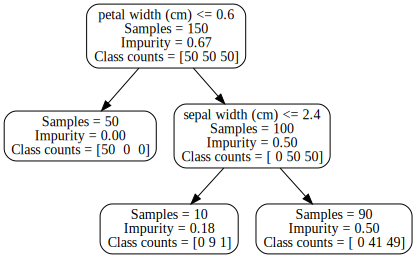

In [7]:
iris_sample_vals = iris_sample.values

# # for small sample
# X = iris_sample_vals[:,:-1]
# y = iris_sample_vals[:,-1]

X = iris_df.values[:,:-1]
y = iris_df.values[:,-1]

logger.setLevel(logging.INFO)

random_forest = RandomForest(n_classes=3, n_trees=3)
random_forest.fit(X, y)

feature_names = iris_data['feature_names']
random_forest.render(tree_id=0, feature_names=feature_names)

### Example prediction on Iris data set

In [8]:
random_forest.predict_proba(X[0:4,:])

array([[0.03875969, 0.77235142, 0.18888889],
       [0.70542636, 0.29457364, 0.        ],
       [0.        , 0.22457912, 0.77542088],
       [0.03875969, 0.77235142, 0.18888889]])

In [9]:
random_forest.predict(X)

array([1, 0, 2, 1, 2, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0,
       1, 2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 2, 0, 2, 0,
       0, 2, 1, 2, 2, 2, 2, 1, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 1,
       1, 2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2,
       0, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 1, 0, 1, 2])

In [10]:
y.astype(int)

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0,
       1, 2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1,
       1, 2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2,
       0, 2, 0, 1, 2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 2])

## Random forest classifier - Titanic data

### Load titanic data set

In [12]:
X_train = pd.read_feather('../data/titanic/processed/X_train.feather')
y_train = pd.read_feather('../data/titanic/processed/y_train.feather')
X_test = pd.read_feather('../data/titanic/processed/X_test.feather')
y_test = pd.read_feather('../data/titanic/processed/y_test.feather')

### Random forest model accuracy

In [13]:
logger.setLevel(logging.WARNING)

titanic_forest = RandomForest(max_depth=2, min_samples_leaf=1, n_trees=50)
titanic_forest.fit(X_train.values, y_train.values)
y_pred = titanic_forest.predict(X_test.values)
test_acc = (y_pred == y_test.values.flatten()).sum() / len(y_test)
print(f'Test accuracy = {test_acc:.2%}')

Test accuracy = 78.77%


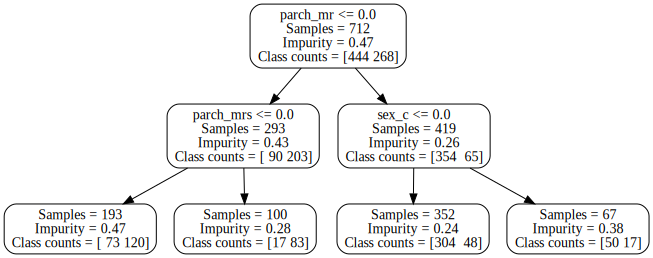

In [14]:
titanic_forest.render(tree_id=3, feature_names=X_train.columns)

## Random forest regressor - Boston housing data

### Load Boston housing data

In [15]:
boston_data = load_boston()
boston_df = pd.DataFrame(boston_data['data'], columns=boston_data['feature_names'])
boston_df['y'] = boston_data['target']
boston_df = boston_df.sample(frac=1, random_state=42).reset_index(drop=True)
boston_sample = boston_df.head(5)
boston_sample

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y
0,0.09178,0.0,4.05,0.0,0.510,6.416,84.1,2.6463,5.0,296.0,16.6,395.50,9.04,23.6
1,0.05644,40.0,6.41,1.0,0.447,6.758,32.9,4.0776,4.0,254.0,17.6,396.90,3.53,32.4
2,0.10574,0.0,27.74,0.0,0.609,5.983,98.8,1.8681,4.0,711.0,20.1,390.11,18.07,13.6
3,0.09164,0.0,10.81,0.0,0.413,6.065,7.8,5.2873,4.0,305.0,19.2,390.91,5.52,22.8
4,5.09017,0.0,18.10,0.0,0.713,6.297,91.8,2.3682,24.0,666.0,20.2,385.09,17.27,16.1


### Fit random forest on Boston data

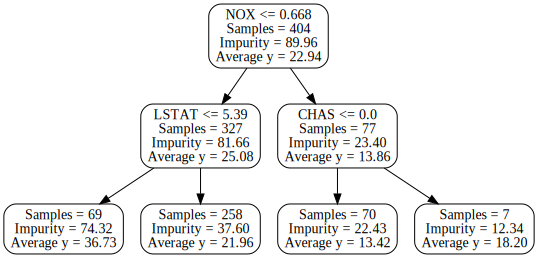

In [16]:
X = boston_df.values[:,:-1]
y = boston_df.values[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
boston_random_forest = RandomForest(
    impurity='mse',
    is_classifier=False,
    n_trees=100,
    max_depth=2)
boston_random_forest.fit(X_train, y_train)

boston_feature_names = boston_data['feature_names']
boston_random_forest.render(tree_id=0,feature_names=boston_feature_names)

### Random forest accuracy on Boston data

In [17]:
y_pred = boston_random_forest.predict(X_test)
test_acc = r2_score(y_test, y_pred)
print(f'Test accuracy (R2 score) = {test_acc:.2%}')

Test accuracy (R2 score) = 61.39%


## end